<a href="https://colab.research.google.com/github/sanjaydasgupta/knn-raspberry-pi-pico/blob/main/knn-pico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# The Training Data-Set

## Generate the Training Data

In [1]:
train_data = []

def generate_training_data():
  global train_data
  train_data = []
  for temp_amb in [10 + 2.5 * n for n in range(13)]:
    for temp_door in [10 + 2.5 * n for n in range(13)]:
      if temp_door < temp_amb - 2.5:
        train_data.append([temp_amb, temp_door, 'ALARM'])
      elif temp_door > temp_amb + 2.5:
        train_data.append([temp_amb, temp_door, 'FAULT'])
      else:
        train_data.append([temp_amb, temp_door, 'NORMAL'])

generate_training_data()

## Visualize the Training Data

169
FAULT     66
ALARM     66
NORMAL    37
Name: state, dtype: int64


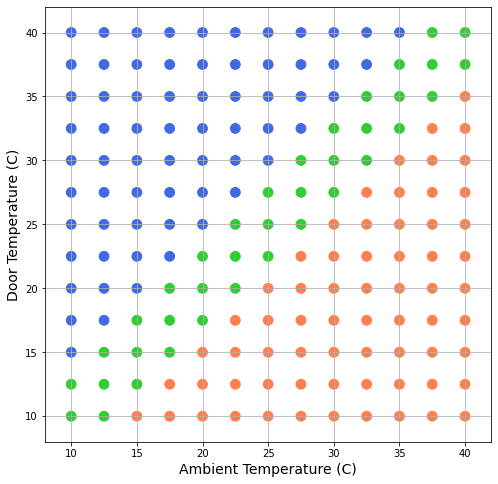

In [2]:
import pandas as pd

df = pd.DataFrame(train_data, columns=['temp-ambient', 'temp-door', 'state'])
print(len(df))
print(df['state'].value_counts())

colormap = {'FAULT': 'royalblue', 'ALARM': 'coral', 'FIRE': 'maroon', 'NORMAL': 'limegreen'}
colors = df['state'].map(colormap)
ax = df.plot(kind='scatter', x='temp-ambient', y='temp-door', grid=True, figsize=(8, 8), c=colors, s=96)
ax.set_xlabel('Ambient Temperature (C)', fontsize=14)
ax.set_xlim([8, 42])
ax.set_ylabel('Door Temperature (C)', fontsize=14)
ax.set_ylim([8, 42])
None

In [3]:
df.sample(5)

,temp-ambient,temp-door,state
151,37.5,30.0,ALARM
98,27.5,27.5,NORMAL
157,40.0,12.5,ALARM
160,40.0,20.0,ALARM
20,12.5,27.5,FAULT


# KNN Prediction

In [4]:
from math import sqrt

def encode_class_names(dataset):
  class_names = [row[-1] for row in dataset]
  class_names_set = set(class_names)
  index_lookup = {name: i for i, name in enumerate(class_names_set)}
  for row in dataset:
    row[-1] = index_lookup[row[-1]]
  return {i: name for i, name in enumerate(class_names_set)}

def distance(row1, row2):
  feature_pairs = zip(row1, row2)
  deltas = [(a - b) for a, b in feature_pairs]
  sum_diagonals_squared = sum([delta ** 2 for delta in deltas])
  return sqrt(sum_diagonals_squared)

def nearest_neighbors(dataset, test_row, num_neighbors):
  distances = [distance(test_row, train_row) for train_row in dataset]
  row_distance_pairs = list(zip(dataset, distances))
  row_distance_pairs.sort(key=lambda tup: tup[1])
  neighbor_rows = [pair[0] for pair in row_distance_pairs[:num_neighbors]]
  return neighbor_rows

def predict(dataset, test_row, num_neighbors):
  neighbors = nearest_neighbors(dataset, test_row, num_neighbors)
  neighbor_class_names = [row[-1] for row in neighbors]
  prediction = max(set(neighbor_class_names), key=neighbor_class_names.count)
  return prediction

## A Quick Test

In [5]:
# Deep copy training-data
dataset_copy = [e[:] for e in train_data[:]]
# convert class column to integers
class_name_table = encode_class_names(dataset_copy)
print(class_name_table)
# define model parameter
num_neighbors = 5
# predict for new test-records
for row in [[35, 25], [25, 35], [25, 24], [35, 33], [30, 32]]:
  label = predict(dataset_copy, row, num_neighbors)
  print('Data=%s, Predicted: %s' % (row, class_name_table[label]))

{0: 'ALARM', 1: 'NORMAL', 2: 'FAULT'}
Data=[35, 25], Predicted: ALARM
Data=[25, 35], Predicted: FAULT
Data=[25, 24], Predicted: NORMAL
Data=[35, 33], Predicted: NORMAL
Data=[30, 32], Predicted: NORMAL


## Prediction Field

In [6]:
dataset_copy = [e[:] for e in train_data[:]]
predictions = []
for temp_amb in [t / 2 for t in range(20, 81)]:
    for temp_door in [t / 2 for t in range(20, 81)]:
      label = predict(dataset_copy, [temp_amb, temp_door], num_neighbors)
      #class_name = class_name_table[label]
      predictions.append([temp_amb, temp_door, label])

df2 = pd.DataFrame(predictions, columns=['temp-ambient', 'temp-door', 'state'])
print(len(df2))
print(df2['state'].value_counts())

3721
FAULT     1424
ALARM     1424
NORMAL     873
Name: state, dtype: int64


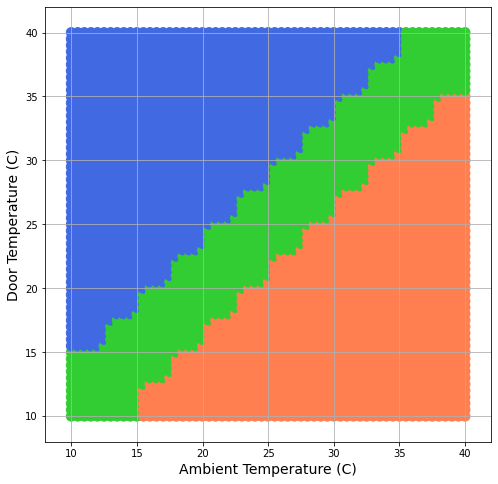

In [7]:
colormap = {'FAULT': 'royalblue', 'ALARM': 'coral', 'FIRE': 'maroon', 'NORMAL': 'limegreen'}
colors = df2['state'].map(colormap)
ax = df2.plot(kind='scatter', x='temp-ambient', y='temp-door', grid=True, figsize=(8, 8), c=colors, s=96)
ax.set_xlabel('Ambient Temperature (C)', fontsize=14)
ax.set_xlim([8, 42])
ax.set_ylabel('Door Temperature (C)', fontsize=14)
ax.set_ylim([8, 42])
None